<a href="https://colab.research.google.com/github/moritzburmester/city-planning-satellite-ml/blob/master/notebooks/city_dev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
''' Uncomment and add the libraries that you need to install'''
#%pip install ultralytics

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from transformers import pipeline
from ultralytics import SAM

# Source/Inspiration: https://medium.com/@nandinilreddy/object-detection-using-text-prompts-owl-vit-sam-e7d73f7b4732

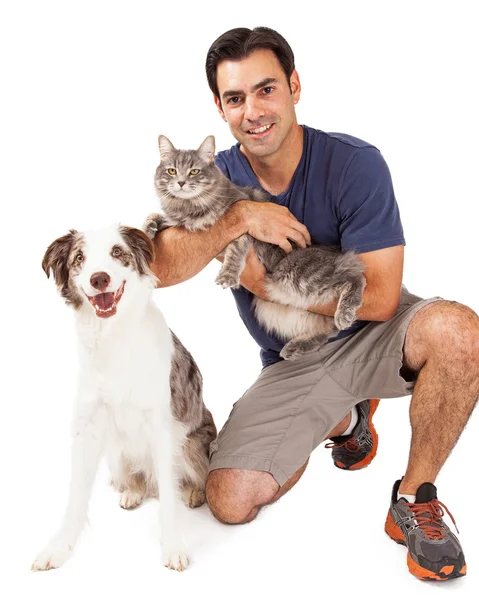

In [ ]:
raw_image = Image.open("cathumandog.jpg")
raw_image

In [ ]:
''' This would be the model that we would be finetuning. We would finetune it on new classes such as benches, bins, street lamps, and street damage
s.t. it can accept these as text prompts. We would then pass the bounding box on to the SAM model.'''

OWL_checkpoint = "google/owlvit-base-patch32"

In [ ]:
detector = pipeline(
    model= OWL_checkpoint,
    task="zero-shot-object-detection",
    device = 0
)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
text_prompt = ['cat', 'dog', 'human']

In [ ]:
output = detector(
    raw_image,
    candidate_labels = text_prompt
)
output

[{'score': 0.2372942566871643,
  'label': 'dog',
  'box': {'xmin': 32, 'ymin': 195, 'xmax': 222, 'ymax': 577}},
 {'score': 0.1797475963830948,
  'label': 'cat',
  'box': {'xmin': 219, 'ymin': 224, 'xmax': 371, 'ymax': 342}}]

The OWL Vit gives us the bounding boxes of the objects we provided in the text prompt.

In [ ]:
image = np.array(raw_image)
image_with_bboxes = image.copy()

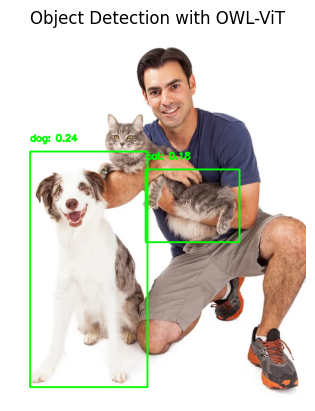

In [ ]:
for obj in output:
    label = obj['label']
    score = obj['score']
    bbox = [obj['box']['xmin'], obj['box']['ymin'], obj['box']['xmax'], obj['box']['ymax']]

    cv2.rectangle(image_with_bboxes, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (0, 255, 0), 2)

    text = f"{label}: {score:.2f}"
    text_size, _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)  # Get text size
    text_origin = (int(bbox[0]), int(bbox[1]) - text_size[1] - 5)  # Position above the box
    cv2.putText(image_with_bboxes, text, text_origin, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

plt.imshow(image_with_bboxes)
plt.title("Object Detection with OWL-ViT")
plt.axis("off")
plt.show()

In [ ]:
SAM_version = "mobile_sam.pt"
model = SAM(SAM_version)

We can pass the bounding boxes to a SAM model and then create the segmentation masks.

In [ ]:
bboxes = []
for obj in output:
    bboxes.append([obj['box']['xmin'], obj['box']['ymin'], obj['box']['xmax'], obj['box']['ymax']])

In [ ]:
labels = np.repeat(1, len(output))
results = model.predict(
    raw_image,
    bboxes=bboxes,
    labels=labels
)


0: 1024x1024 1 0, 1 1, 85.4ms
Speed: 6.0ms preprocess, 85.4ms inference, 0.8ms postprocess per image at shape (1, 3, 1024, 1024)


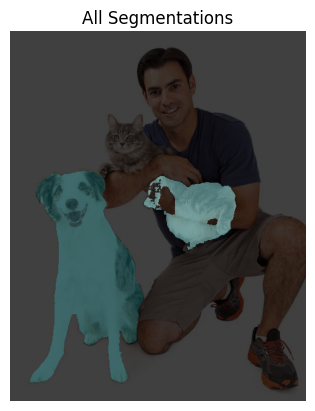

In [ ]:
image_with_all_masks = image.copy()

for i, result in enumerate(results):
    masks = result.masks.data
    masks = masks.cpu().numpy().squeeze()

    for j, mask in enumerate(masks):
        color = np.random.randint(0, 256, size=3)
        colored_mask = np.zeros_like(image)
        colored_mask[mask] = color

        alpha = 0.5
        image_with_all_masks = cv2.addWeighted(image_with_all_masks, 1 - alpha, colored_mask, alpha, 0)

plt.imshow(image_with_all_masks)
plt.title("All Segmentations")
plt.axis("off")
plt.show()

I guess it doesn't work perfectly yet haha